In [1]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [3]:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [4]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2019)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [5]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs.csv", index=False)

In [3]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#The first 5 rows:
docs_df.head()

,id,authors,title,doi,category,abstract
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)..."


In [ ]:
# Listing categories
categories = list(docs_df['category'].unique())
for i in categories:
    print(i)
        

In [5]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [6]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [7]:
df = pd.read_csv("../Data/trimmed_arxiv_docs.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377629 entries, 0 to 377628
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        377629 non-null  object
 1   authors   377629 non-null  object
 2   title     377629 non-null  object
 3   doi       117502 non-null  object
 4   category  377629 non-null  object
 5   abstract  377629 non-null  object
dtypes: object(6)
memory usage: 17.3+ MB


In [8]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [9]:
df['abstract'].describe(include='all')

count                                                377629
unique                                               377559
top         This article focuses on the development of h...
freq                                                      2
Name: abstract, dtype: object

In [10]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                377559
unique                                               377559
top         The first report of phase separation in meta...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [11]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [12]:
df

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377625,quant-ph/0604056,Scott Aaronson and Greg Kuperberg,Quantum Versus Classical Proofs and Advice,NaN,"['quant-ph', 'cs.CC']",This paper studies whether quantum proofs ar...,174,"[quant-ph, cs.CC]","[quant-ph, cs]"
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [40]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [41]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
30,801.3697,George I. Bell,The mathematics of Septoku,NaN,"['math.CO', 'cs.DM', 'math.GM']",Septoku is a Sudoku variant invented by Bruc...,93,"[math.CO, cs.DM, math.GM]","[math, cs]"
39,805.1293,Avik Chakraborty,Testability of Reversible Iterative Logic Arrays,NaN,['cs.OH'],Iterative Logic Arrays (ILAs) are ideal as V...,227,[cs.OH],[cs]
43,806.0557,"Qin Li, Chengqing Li, Chunhui Wu, Dongyang Lon...",An efficient and provably secure arbitrated qu...,NaN,"['quant-ph', 'cs.CR']","In this paper, an efficient arbitrated quant...",120,"[quant-ph, cs.CR]","[quant-ph, cs]"
57,809.2093,"Troy Lee, Adi Shraibman",An approximation algorithm for approximation rank,NaN,['cs.CC'],One of the strongest techniques available fo...,188,[cs.CC],[cs]
65,810.484,"Dorit Aharonov, Michael Ben-Or, Fernando G.S.L...",The Pursuit of Uniqueness: Extending Valiant-V...,NaN,"['quant-ph', 'cs.CC']",Valiant-Vazirani showed in 1985 [VV85] that ...,195,"[quant-ph, cs.CC]","[quant-ph, cs]"
...,...,...,...,...,...,...,...,...,...
377513,cs/0606037,Andrej Bogdanov and Luca Trevisan,Average-Case Complexity,NaN,['cs.CC'],We survey the average-case complexity of pro...,170,[cs.CC],[cs]
377514,cs/0608050,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,10.1016/j.tcs.2010.11.041,"['cs.DS', 'cond-mat.dis-nn', 'physics.soc-ph']",Dense sub-graphs of sparse graphs (communiti...,122,"[cs.DS, cond-mat.dis-nn, physics.soc-ph]","[cs, cond-mat, physics]"
377515,cs/0610128,Daniel Lemire and Owen Kaser,Hierarchical Bin Buffering: Online Local Momen...,10.1145/1328911.1328925,"['cs.DS', 'cs.DB']","Local moments are used for local regression,...",184,"[cs.DS, cs.DB]",[cs]
377547,math/0008020,Matthieu Latapy and Thi Ha Duong Phan,The Lattice of integer partitions and its infi...,10.1016/j.disc.2008.02.002,"['math.CO', 'cs.NA', 'math.DS', 'math.NA', 'ma...","In this paper, we use a simple discrete dyna...",152,"[math.CO, cs.NA, math.DS, math.NA, math.NT]","[math, cs]"


In [42]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [43]:
df_random

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377623,quant-ph/0411039,Sofia Wechsler,What was in the apparatus before the click,NaN,['quant-ph'],When a quantum system is described by a wave...,144,[quant-ph],[quant-ph]
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [44]:
# Reduce the size of the data
df_cs = df_cs.sample(10000, random_state=42)
df_random = df_random.sample(10000, random_state=42)

In [45]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [46]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [47]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low)
df_random['cleaned'] = df_random.abstract.apply(low)


In [22]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [49]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(cleanPunct)
df_random['cleaned'] = df_random.cleaned.apply(cleanPunct)
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [50]:
# View dataframe
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[this, chapter, focuses, on, the, performance,...","[(this, chapter), (chapter, focuses), (focuses...","[(this, chapter, focuses), (chapter, focuses, ..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[much, recent, work, suggests, that, incorpora...","[(much, recent), (recent, work), (work, sugges...","[(much, recent, work), (recent, work, suggests..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, in, both, li...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, is, increasi...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[this, paper, develops, kl-ergodic, exploratio...","[(this, paper), (paper, develops), (develops, ...","[(this, paper, develops), (paper, develops, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[here, we, present, a, new, approach, based, o...","[(here, we), (we, present), (present, a), (a, ...","[(here, we, present), (we, present, a), (prese..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[with, the, popularity, of, photographic, equi...","[(with, the), (the, popularity), (popularity, ...","[(with, the, popularity), (the, popularity, of..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[the, quality, of, healthcare, provided, by, h...","[(the, quality), (quality, of), (of, healthcar...","[(the, quality, of), (quality, of, healthcare)..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[we, present, an, integrated, approach, for, p...","[(we, present), (present, an), (an, integrated...","[(we, present, an), (present, an, integrated),..."


In [25]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [26]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [27]:
from collections import Counter
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [28]:
print(len(trigram_cs))

1235555


In [29]:
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords]

In [51]:
df_cs['cleaned'] = df_cs.cleaned.apply(clean)
df_random['cleaned'] = df_random.cleaned.apply(clean)
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [52]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[(chapter, focuses), (focuses, performance), (...","[(chapter, focuses, performance), (focuses, pe..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[(recent, work), (work, suggests), (suggests, ...","[(recent, work, suggests), (work, suggests, in..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[(paper, develops), (develops, kl-ergodic), (k...","[(paper, develops, kl-ergodic), (develops, kl-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[(present, new), (new, approach), (approach, b...","[(present, new, approach), (new, approach, bas..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, photographic, equipment, people, ...","[(popularity, photographic), (photographic, eq...","[(popularity, photographic, equipment), (photo..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[(quality, healthcare), (healthcare, provided)...","[(quality, healthcare, provided), (healthcare,..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[(present, integrated), (integrated, approach)...","[(present, integrated, approach), (integrated,..."


In [53]:
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [ ]:
print(trigram_cs)

#trigrams - 20+
#bigrams - 40+
#unigrams - quite irrelevant, but maybe 100+

In [54]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [55]:
trim_value = 7
unigram_cs = trim(unigram_cs, trim_value)
unigram_rand = trim(unigram_rand, trim_value)
bigram_cs = trim(bigram_cs, trim_value)
bigram_rand = trim(bigram_rand, trim_value)
trigram_cs = trim(trigram_cs, trim_value)
trigram_rand = trim(trigram_rand, trim_value)

In [56]:
print(len(trigram_rand))

610


In [ ]:
range_n_clusters = range(20,44,2)
silhouette(range_n_clusters)

For n_clusters = 20 The average silhouette_score is : 0.05117379201925683
For n_clusters = 22 The average silhouette_score is : 0.050663568444635244
For n_clusters = 24 The average silhouette_score is : 0.050683985722015774
For n_clusters = 26 The average silhouette_score is : 0.051105952139443155
For n_clusters = 28 The average silhouette_score is : 0.05024613998913728
For n_clusters = 30 The average silhouette_score is : 0.050221921776679286
For n_clusters = 32 The average silhouette_score is : 0.046764885886183584
For n_clusters = 34 The average silhouette_score is : 0.04999361682549239
For n_clusters = 36 The average silhouette_score is : 0.048637743716813446
For n_clusters = 38 The average silhouette_score is : 0.047620685878898304
For n_clusters = 40 The average silhouette_score is : 0.04782840019072345
For n_clusters = 42 The average silhouette_score is : 0.04959535618001115


In [57]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[(chapter, focuses), (focuses, performance), (...","[(chapter, focuses, performance), (focuses, pe..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[(recent, work), (work, suggests), (suggests, ...","[(recent, work, suggests), (work, suggests, in..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[(paper, develops), (develops, kl-ergodic), (k...","[(paper, develops, kl-ergodic), (develops, kl-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[(present, new), (new, approach), (approach, b...","[(present, new, approach), (new, approach, bas..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, photographic, equipment, people, ...","[(popularity, photographic), (photographic, eq...","[(popularity, photographic, equipment), (photo..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[(quality, healthcare), (healthcare, provided)...","[(quality, healthcare, provided), (healthcare,..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[(present, integrated), (integrated, approach)...","[(present, integrated, approach), (integrated,..."


In [147]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [148]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

Feature Selection on CS vs Random

In [149]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [150]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [151]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for item in C:
        if term in item:
            a += 1
        else:
            c += 1
    for item in notC:
        if term in item:
            b += 1
        else:
            d += 1
    return a,b,c,d


In [152]:
# Calculate chi2 values for each word
from collections import Counter

def createTermLists(cat, nonCat):
    # Find number of times term and class co-occur
    wordsC = Counter()
    for items in cat:
        wordsC = wordsC + Counter(items)
    return wordsC


In [153]:
def findChiValues(cat, nonCat):
    wordsC = createTermLists(cat, nonCat)
    chi_values = {}
    for term in wordsC:
        a,b,c,d = findOccurrences(term, cat, nonCat)
        n = len(cat) + len(nonCat)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [154]:
chi_values_uni = findChiValues(df_cs.cleaned, df_random.cleaned)

In [155]:
print(len(chi_values_uni))

10646


In [156]:
chi_values_bi = findChiValues(df_cs.bigrams, df_random.bigrams)
chi_values_tri = findChiValues(df_cs.trigrams, df_random.trigrams)

In [157]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [158]:
chiVal = 40
chi_best_uni = selectChiBest(chi_values_uni, chiVal)
chi_best_bi = selectChiBest(chi_values_bi, chiVal)
chi_best_tri = selectChiBest(chi_values_tri, chiVal)

print(chi_best_tri)

{'deep-neural-networks': 284.2431318252851, 'convolutional-neural-networks': 155.40651231961044, 'code-available-https': 155.19500151163962, 'convolutional-neural-network': 153.435194534182, 'natural-language-processing': 150.11838194549392, 'paper-propose-novel': 140.34559129935087, 'machine-learning-models': 114.65352509303027, 'reinforcement-learning-rl': 107.5755290805811, 'deep-learning-models': 106.56479340504674, 'deep-reinforcement-learning': 103.53319595918983, 'deep-neural-network': 101.3173157037755, 'experimental-results-demonstrate': 99.49248781468268, 'generative-adversarial-networks': 85.36279186542806, 'neural-networks-cnns': 79.313287485568, 'neural-networks-dnns': 78.30539102499749, 'graph-neural-networks': 74.2748168222423, 'recurrent-neural-network': 71.25294796527673, 'artificial-intelligence-ai': 67.22520443485676, 'deep-learning-based': 64.20545746388443, 'demonstrate-effectiveness-proposed': 63.19907709284245, 'work-propose-novel': 61.186619188525, 'paper-propos

In [160]:
import json
chi_vals = [chi_best_uni, chi_best_bi, chi_best_tri]
with open('chi_data.json', 'w') as f:
    json.dump(chi_vals, f)

In [161]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories']].copy()
df_tmp = df_random[['abstract', 'list_categories', 'main_categories']].copy()
df_combined = df_combined.append(df_tmp)

df_combined

,abstract,list_categories,main_categories
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]"
160796,Much recent work suggests that incorporating...,[cs.CL],[cs]
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs]
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs]
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs]
...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat]
13291,We prove a general result about the stabilit...,[math.DG],[math]
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]"
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]"


In [162]:
# Filter
def filterAbstract(text, chi_best_bi, chi_best_tri):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w not in punctuation]
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1

    return new2


In [163]:
df_combined['filteredAbstracts'] = df_combined.abstract.apply(filterAbstract, chi_best_bi = chi_best_bi, chi_best_tri = chi_best_tri)

In [164]:
print(list(df_combined.filteredAbstracts.head(3)))

[['this', 'chapter', 'focuses', 'on', 'the', 'performance', 'enhancement', 'brought', 'by', 'the', 'addition', 'of', 'caching', 'capabilities', 'to', 'full-duplex', 'fd', 'radios', 'in', 'the', 'context', 'of', 'ultra-dense', 'networks', 'udns', 'more', 'specifically', 'we', 'aim', 'at', 'showing', 'that', 'the', 'interference', 'footprint', 'of', 'such', 'networks', 'i.e.', 'the', 'major', 'bottleneck', 'to', 'overcome', 'to', 'observe', 'the', 'theoretical', 'fd', 'throughput', 'doubling', 'at', 'the', 'network', 'level', 'can', 'be', 'significantly', 'reduced', 'thanks', 'to', 'edge', 'caching', 'fundamental', 'results', 'show', 'that', 'most', 'of', 'the', 'gain', 'as', 'compared', 'to', 'their', 'half-duplex', 'hd', 'counterparts', 'can', 'be', 'achieved', 'by', 'such', 'networks', 'only', 'if', 'costly', 'modifications', 'to', 'their', 'infrastructure', 'are', 'performed', 'and/or', 'if', 'high-rate', 'signaling', 'is', 'exchanged', 'between', 'user', 'equipments', 'ues', 'over',

In [172]:
def filterAdvance(text):
    return [w for w in text if (w in chi_best_uni or w in chi_best_bi or w in chi_best_tri) and w in dictCombined and len(w)>1]

In [166]:
# Remove stop words
df_combined['filteredAbstracts'] = df_combined.filteredAbstracts.apply(clean)

In [ ]:
dictCombined = createDict(df_combined['filteredAbstracts'])
trim_value = 7
dictCombined = trim(dictCombined, trim_value)
print(dictCombined)

In [173]:
# Filter out unigrams as well
df_combined['doubleFilteredAbstracts'] = df_combined.filteredAbstracts.apply(filterAdvance)

In [197]:
print(list(df_combined.doubleFilteredAbstracts.head(1)))

[['focuses', 'performance', 'caching', 'capabilities', 'context', 'networks', 'specifically', 'aim', 'networks', 'i.e.', 'bottleneck', 'overcome', 'throughput', 'network', 'significantly', 'caching', 'results', 'compared', 'achieved', 'networks', 'costly', 'infrastructure', 'user', 'control', 'aim', 'proposing', 'based', 'popular', 'network', 'network', 'associated', 'wireless', 'node', 'content', 'caching', 'policy', 'capturing', 'popularity', 'corresponding', 'calculate', 'successful', 'corresponding', 'throughput', 'network', 'approach', 'leverages', 'tools', 'geometry', 'guarantee', 'problem', 'results', 'simulations', 'networks']]


In [195]:
# Make a list of unified abstracts
abstracts = []
for item in df_combined.doubleFilteredAbstracts:
    abstracts.extend(item)

In [196]:
abstractDict = Counter(abstracts)
abstractDict = trim(abstractDict, 7)
len(abstractDict)

1739

In [198]:
import itertools
with open('abstractDict.json', 'w') as f:
    json.dump(abstractDict, f)

In [199]:
import itertools
with open('abstracts.txt', 'w') as f:
    f.write(str(abstracts))

In [200]:
corpus = " ".join(abstracts)
with open('../glove/merged_abstracts.txt', 'w') as f:
    f.write(corpus)

In [201]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [202]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,doubleFilteredAbstracts
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[focuses, performance, caching, capabilities, ..."
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent, work, information, improve, task-spec..."
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[hierarchical, natural-language-processing, nl..."
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[detection, increasingly, important, research,..."
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[paper, exploration, equilibrium, \text, ^3, m..."
...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, in-situ, probes, ...","[quantum, probes, quantum, dirac, spin, import..."
13291,We prove a general result about the stabilit...,[math.DG],[math],"[prove, general, result, stability, geometric,...","[prove, result, closed, '', sections, compact,..."
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[consider, quantum, stochastic, processes, dis...","[quantum, discuss, formalism, fluctuations, qu..."
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[paper, study, ideals, arising, moments, local...","[paper, study, moments, dirac, provide, case, ..."


GLoVe Embeddings

In [203]:
import json
chi_values_list = []
with open('chi_data.json') as f:
    for jsonObj in f:
        chi_values_dict = json.loads(jsonObj)
        chi_values_list.append(chi_values_dict)

In [204]:
chi_values_list = chi_values_list[0]

In [205]:
chi_values_list

[{'learning': 3074.555727628824,
  'performance': 2010.4689464368037,
  'propose': 1983.241364151793,
  'training': 1730.4314799450503,
  'neural': 1683.8631816980946,
  'network': 1675.0816596235015,
  'proposed': 1493.1499893307441,
  'state-of-the-art': 1458.8801792902048,
  'networks': 1319.256899424778,
  'datasets': 1308.4952885159469,
  'tasks': 1274.162310277148,
  'paper': 1270.8325912890202,
  'deep': 1270.7254235896041,
  'methods': 1180.2468065922649,
  'task': 1163.6485800431856,
  'dataset': 1015.9301079371821,
  'novel': 974.2526276775709,
  'algorithm': 963.961135042794,
  'algorithms': 948.0219606621092,
  'data': 904.7918254168274,
  'quantum': 891.0567042852821,
  'existing': 885.0343032624083,
  'problem': 848.6676126648457,
  'information': 778.8527239955812,
  'accuracy': 751.715600216933,
  'experiments': 729.9527319418962,
  'trained': 721.9994159707878,
  'image': 714.1670870478893,
  'learn': 698.6483803885063,
  'machine': 694.5127933736717,
  'method': 691.5

In [206]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

21653 words loaded!
[ 0.755545  0.459023  1.060876 -1.087209  0.182513 -0.455297 -0.843645
  1.312872  0.136671  0.135661  0.37548   1.292188  0.96687  -0.945487
 -0.588714 -0.386512 -0.502687  0.354914 -0.749833  0.134328  0.501346
 -0.526756  0.334052  0.366274 -0.135113 -0.097292 -0.640214  0.916955
  0.043713  1.024583 -0.37078   0.08902   0.341907 -0.44818  -0.075504
 -0.389912 -0.776739  1.026474 -0.183867 -0.686021 -1.009947 -0.937531
  0.121471  0.087806 -1.269744 -0.457104 -0.14152   0.926565  0.237269
 -0.8306  ]


In [207]:
print(vectors['paper'].shape)

(50,)


In [208]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [209]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [210]:
termDict = createVectors(abstractDict.keys(), vectors)

Clustering

In [212]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [263]:
k = 30
kmeans = KMeans(n_clusters=k, random_state=42)

np_vectors= list(termDict.values())

In [264]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50
        

In [265]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

Visualisation

In [266]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

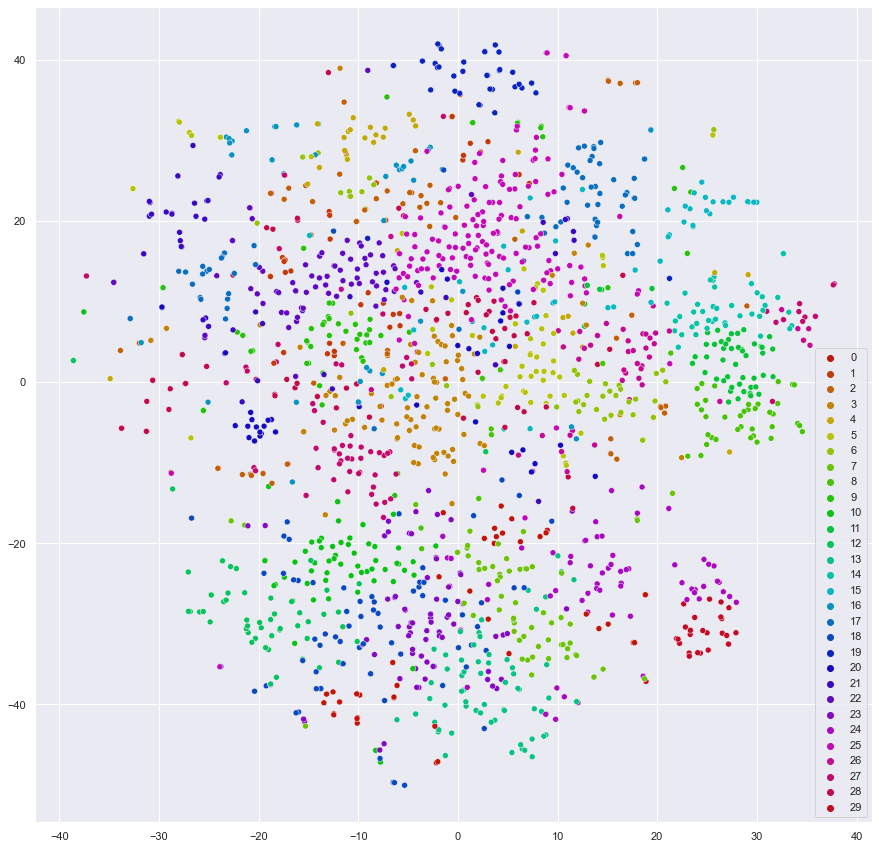

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend='full')

In [268]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [219]:
n = findNearestNeighbour('deep-neural-networks', vectors)
neighbourTerms = pd.DataFrame({n[0]:n[1:]})
n = findNearestNeighbour('computer-vision', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('natural-language-processing', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('algorithm', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('machine-learning', vectors)
neighbourTerms[n[0]] = n[1:]

neighbourTerms

,deep-neural-networks,computer-vision,natural-language-processing,algorithm,machine-learning
0,dnns,natural-language-processing,nlp,algorithms,deep-learning
1,deep-learning,deep-learning,nlp-tasks,method,techniques
2,dnn,nlp,computer-vision,optimal,machine-learning-models
3,neural-networks,recent-years,biomedical,optimization,approaches
4,machine-learning,image-processing,image-processing,proposed,modern
5,machine-learning-models,advances,topic,uses,deep-neural-networks
6,machine-learning-algorithms,deep-learning-methods,advances,approach,tools
7,deep-learning-models,nowadays,tasks,efficient,methods
8,deep-neural-network,great,deep-learning,apply,applications


Silhouette Score for determining the best number of clusters

In [251]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def silhouette(range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        silhouette_avg = silhouette_score(np_vectors, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
silhouette(range_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.09496130901116404
For n_clusters = 5 The average silhouette_score is : 0.04987807140061146
For n_clusters = 10 The average silhouette_score is : 0.038538218917067664
For n_clusters = 15 The average silhouette_score is : 0.04353721741635714
For n_clusters = 20 The average silhouette_score is : 0.04073686255664032
For n_clusters = 25 The average silhouette_score is : 0.038122870199109093
For n_clusters = 30 The average silhouette_score is : 0.03780362055078494
For n_clusters = 35 The average silhouette_score is : 0.04136367006334092
For n_clusters = 38 The average silhouette_score is : 0.04024494718876258
For n_clusters = 40 The average silhouette_score is : 0.0399862729491863
For n_clusters = 45 The average silhouette_score is : 0.038479837110829584


In [221]:
range_n_clusters = range(8,15)
silhouette(range_n_clusters)

For n_clusters = 8 The average silhouette_score is : 0.04458438907763362
For n_clusters = 9 The average silhouette_score is : 0.04186070207255479
For n_clusters = 10 The average silhouette_score is : 0.038538218917067664
For n_clusters = 11 The average silhouette_score is : 0.04414345056451189
For n_clusters = 12 The average silhouette_score is : 0.0436986848094399
For n_clusters = 13 The average silhouette_score is : 0.041475059436169436
For n_clusters = 14 The average silhouette_score is : 0.043968739032653394


Elbow method for determining the best number of clusters

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def elbow(range_n_clusters):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        distortions.append(sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                            'euclidean'), axis=1)) / len(np_vectors))
        inertias.append(clusterer.inertia_)
    
        mapping1[k] = sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                    'euclidean'), axis=1)) / len(np_vectors)
        mapping2[k] = clusterer.inertia_

    plt.plot(range_n_clusters, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

elbow(range_n_clusters)

In [ ]:
range_n_clusters = range(8,16)
elbow(range_n_clusters)

In [253]:
for center in kmeans.cluster_centers_:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [254]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [262]:
centers = kmeans.cluster_centers_
n = findNearestNeighbourVec(centers[0], vectors)
neighbourTerms2 = pd.DataFrame({n[0]:n[1:]})
for i in range(len(centers)):
    n = findNearestNeighbourVec(centers[i], vectors)
    print(i,n)
    neighbourTerms2[n[0]] = n[1:]

neighbourTerms2

0 ['uses', 'combines', 'framework', 'novel', 'propose', 'encoding', 'approach', 'architecture', 'leveraging', 'combine']
1 ['energy', 'kinetic', 'flux', 'energies', 'dissipation', 'density', 'mass', 'momentum', 'harvested', 'electron']
2 ['validate', 'extensive-experiments', 'effectiveness', 'experimental-results', 'benchmark-datasets', 'real-world-datasets', 'efficacy', 'conducted', 'proposed-approach', 'verify']
3 ['material', 'materials', 'bulk', 'magnetic', 'thermal', 'crystal', 'electronic', 'mechanical', 'temperature', 'transport']
4 ['topological', 'lattice', 'phases', 'symmetry', 'dirac', 'ground-state', 'gapped', 'states', 'symmetries', 'one-dimensional']
5 ['deep-learning', 'recent-years', 'computer-vision', 'advances', 'machine-learning', 'approaches', 'recent', 'deep-neural-networks', 'natural-language-processing', 'techniques']
6 ['prove', 'obtain', 'general', 'particular', 'theory', 'form', 'equations', 'case', 'result', 'integral']
7 ['annotations', 'expensive', 'labeled

,uses,energy,validate,material,topological,deep-learning,prove,annotations,performance,reinforcement-learning,...,latency,social-media,autonomous,object,dark,algebraic,solving,outperforms,stellar,encoder-decoder
0,combines,kinetic,extensive-experiments,materials,lattice,recent-years,obtain,expensive,accuracy,rl,...,costs,twitter,environments,3d,matter,closed,solve,baselines,star,long-short-term-memory
1,framework,flux,effectiveness,bulk,phases,computer-vision,general,labeled-data,improve,policy,...,computation,public,navigation,images,sector,lie,problems,state-of-the-art-methods,formation,transformer
2,novel,energies,experimental-results,magnetic,symmetry,advances,particular,annotated,significantly,agent,...,cost,collected,environment,image,standard-model,compact,optimization,significantly-outperforms,galaxies,convolutional-neural-network
3,propose,dissipation,benchmark-datasets,thermal,dirac,machine-learning,theory,annotation,improved,reinforcement-learning-rl,...,energy-consumption,news,robots,scene,scalar,projective,problem,approach-outperforms,disk,convolutional
4,encoding,density,real-world-datasets,crystal,ground-state,approaches,form,training-data,compared,policies,...,memory,clinical,robot,camera,higgs,family,optimization-problem,previous-state-of-the-art,galaxy,lstm
5,approach,mass,efficacy,electronic,gapped,recent,equations,labels,better,deep-reinforcement-learning,...,resources,genomics,vehicles,video,neutrino,manifolds,optimal,state-of-the-art,stars,cnn
6,architecture,momentum,conducted,mechanical,states,deep-neural-networks,case,manually,achieve,model-based,...,reduce,health,robotic,object-detection,gauge,rational,algorithm,outperform,host,attention-mechanism
7,leveraging,harvested,proposed-approach,temperature,symmetries,natural-language-processing,result,require,improves,multi-agent,...,resource,medical,autonomous-driving,pose,bosons,finite,solved,outperforming,dust,recurrent-neural-network
8,combine,electron,verify,transport,one-dimensional,techniques,integral,time-consuming,achieving,marl,...,computational,publicly-available,mobile,visual,masses,group,solution,large-margin,gas,feed-forward


In [271]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [277]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [304]:
clusters[25]

['leverages',
 'task-specific',
 'named',
 'graph-neural-network',
 'prior-work',
 'learning-tasks',
 'synthesizing',
 'multi-task',
 'few-shot',
 'learning-based',
 'novel-method',
 'pipeline',
 'utilizes',
 'neural-network-models',
 'framework-called',
 'generative-adversarial-network',
 'machine-learning-algorithms',
 'proposes',
 'generative-models',
 'enforce',
 'aware',
 'deep-neural',
 'network-based',
 'learning-algorithms',
 'deep-learning-models',
 'black-box',
 'existing-works',
 'adversarial-attacks',
 'lightweight',
 'defense',
 'paper-introduces',
 'improves-performance',
 'model-trained',
 'machine-learning-methods',
 'combines',
 'paper-describes',
 'image-analysis',
 'idea',
 'supervised',
 'deep-learning-based',
 'utilizing',
 'encourage',
 'discriminator',
 'multi-modal',
 'graph-based',
 'transfer-learning',
 'adopt',
 'paper-proposes',
 'ml',
 'frameworks',
 'incremental',
 'integrating',
 'off-the-shelf',
 'self-supervised',
 'contrastive',
 'learnable',
 'express